In [2]:
%matplotlib inline
import sys
BIN = ''
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms
import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from fastai import data_block, basic_train, basic_data
import fastai

import utils

In [3]:
from nn_utils import AE_basic, AE_bn, AE_LeakyReLU, AE_bn_LeakyReLU

In [4]:
# Load data
#train = pd.read_pickle(BIN + 'processed_data/aod/partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/partial_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/full_test.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test.pkl')

train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_train_10percent.pkl')
original_train_shape = train.shape
print('Original train.shape:', original_train_shape)
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_partial_test_10percent.pkl')

#train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_train.pkl')
#test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_full_test.pkl')

Original train.shape: (956154, 29)


In [5]:
# Remove extreme/bad jets
train = utils.filter_jets(train)
test = utils.filter_jets(test)

In [6]:
train.shape

(952063, 27)

In [8]:
print('Number of jets excluded:')
(original_train_shape[0] - train.shape[0])

Number of jets excluded:


4091

In [9]:
# Some jets appear to have zero mass...
np.sum(train['m']==0)

5064

In [10]:
len(train.keys())

27

In [11]:
train.head()

,pt,eta,phi,m,ActiveArea,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,AverageLArQF,...,LeadingClusterCenterLambda,LeadingClusterPt,LeadingClusterSecondLambda,LeadingClusterSecondR,N90Constituents,EMFrac,HECFrac,Timing,OotFracClusters10,OotFracClusters5
0,99.859094,-0.342858,2.134567,8.093726,0.478719,-0.353398,0.132767,2.131208,0.469330,108.751984,...,1264.798706,25.836232,343.890344,43.809391,5.0,0.612864,0.000000,0.864557,0.007613,0.017692
1,45.352539,-0.454986,-2.667796,6.373730,0.498666,-0.469833,0.140288,-2.671408,0.489406,837.354065,...,1027.079468,19.099195,54.438531,72.658773,6.0,0.509103,0.000000,11.380662,0.495797,0.590913
2,26.483807,1.440664,1.628155,5.337418,0.538559,1.447917,0.156741,1.641177,0.527291,293.155884,...,95.400406,4.939110,2.175471,5.361905,5.0,0.401359,0.000000,1.700485,0.188751,0.188751
3,21.745404,-0.112350,-2.588387,4.982306,0.448799,-0.128731,0.126130,-2.650139,0.442389,263.850281,...,84.082619,10.380062,20.607902,6.131678,8.0,0.863900,0.000000,1.283107,0.090132,0.145812
4,87.560859,-2.752789,-2.295353,16.907717,0.518612,-2.782047,0.150488,-2.293478,0.508540,3159.353760,...,921.882202,39.378828,81.567531,13.050796,4.0,0.565845,0.434155,-1.213494,0.000000,0.000000


In [12]:
def plot_all(data, logy=False):
    for key in data.keys():
        plt.figure()
        plt.hist(data[key], bins=200)
        plt.xlabel(str(key))
        plt.ylabel('Number of jets')
        if logy:
            plt.yscale('log')
        else:
            ms.sciy()

In [13]:
plt.close('all')

/home/skelpdar/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


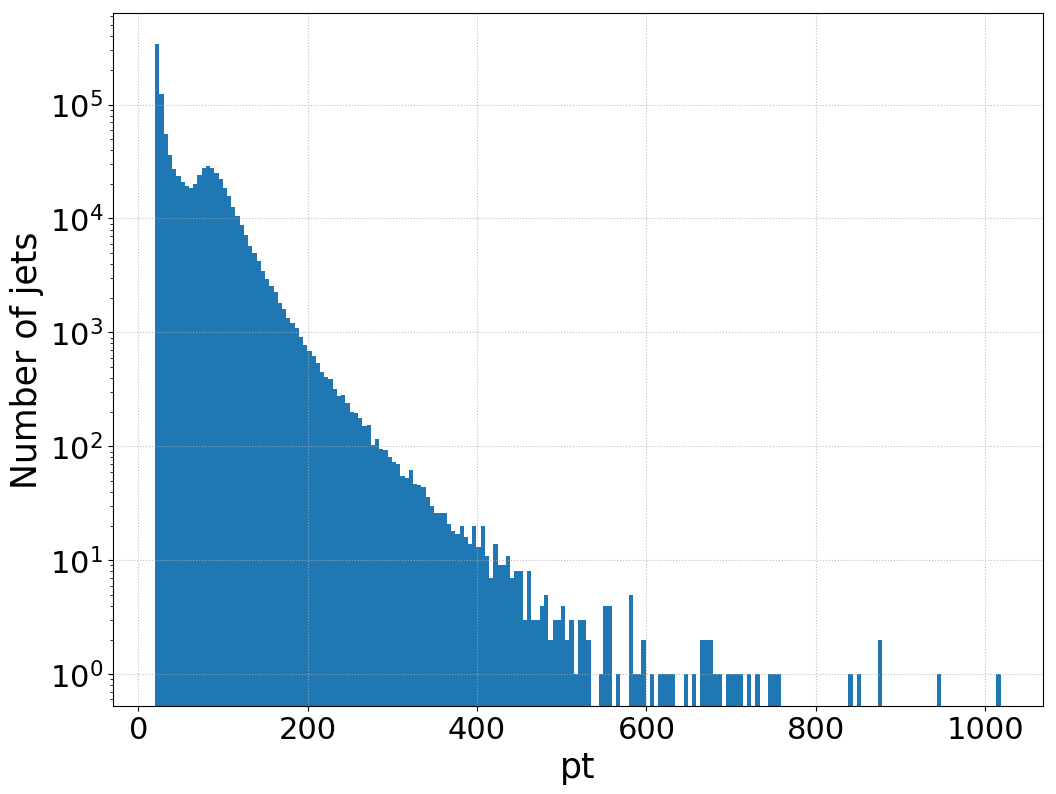

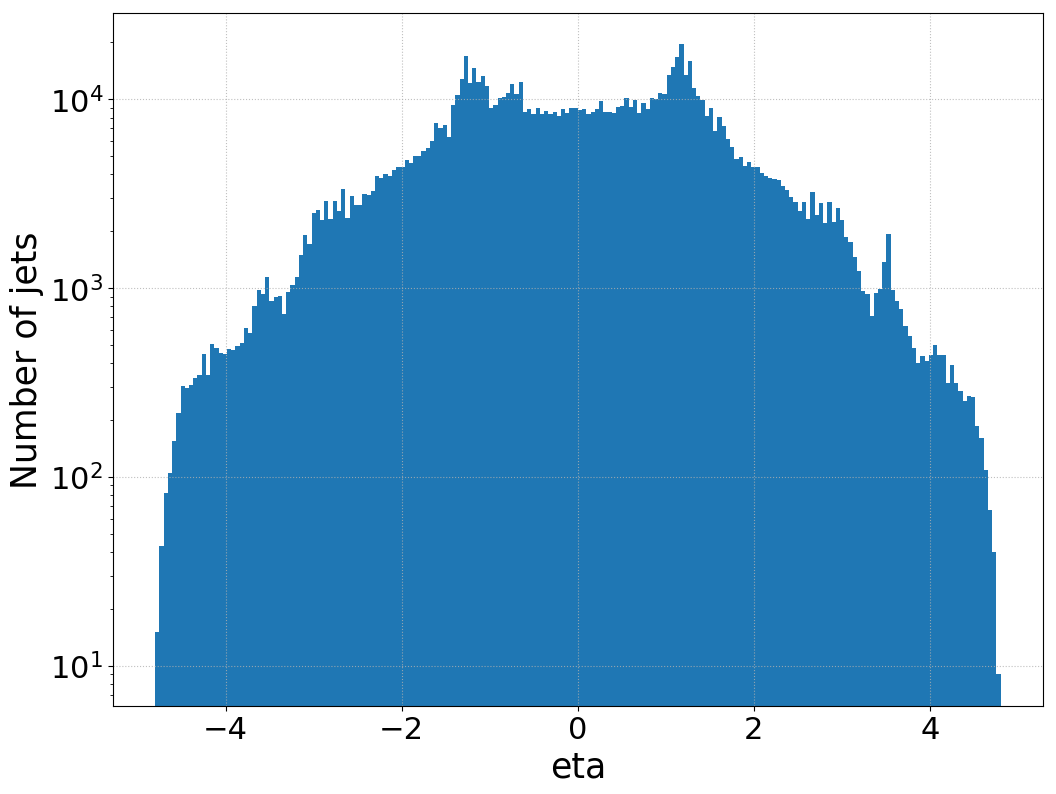

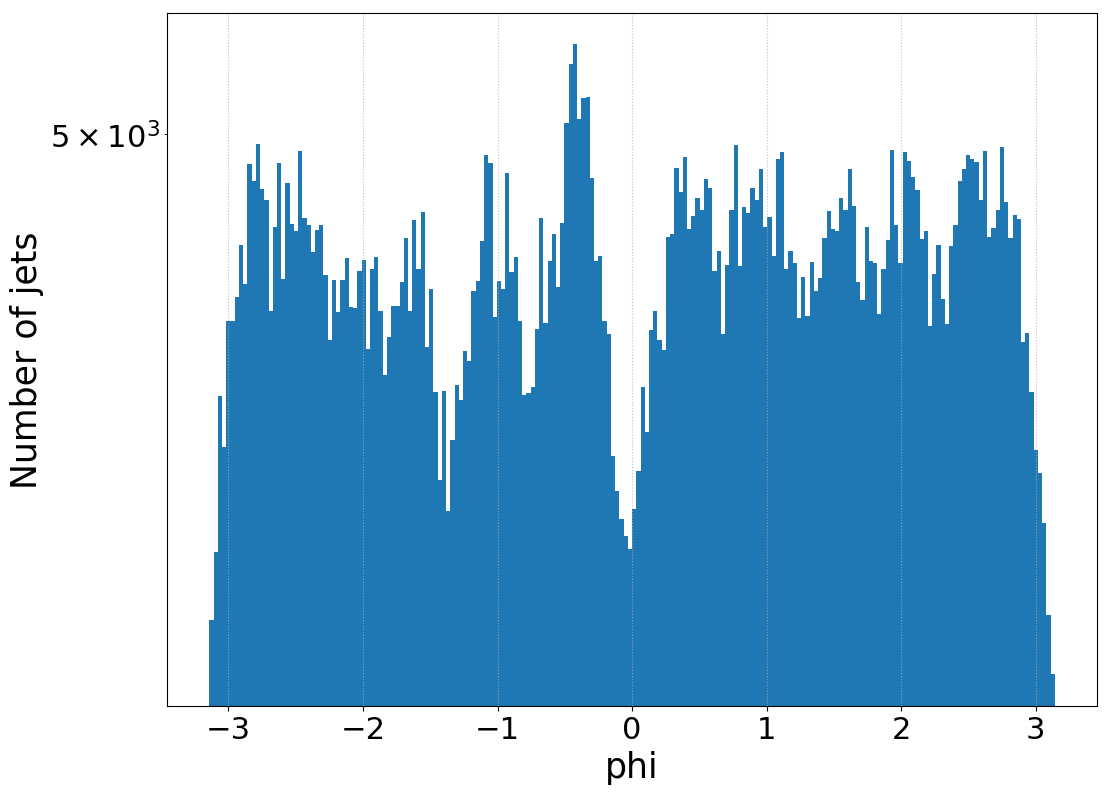

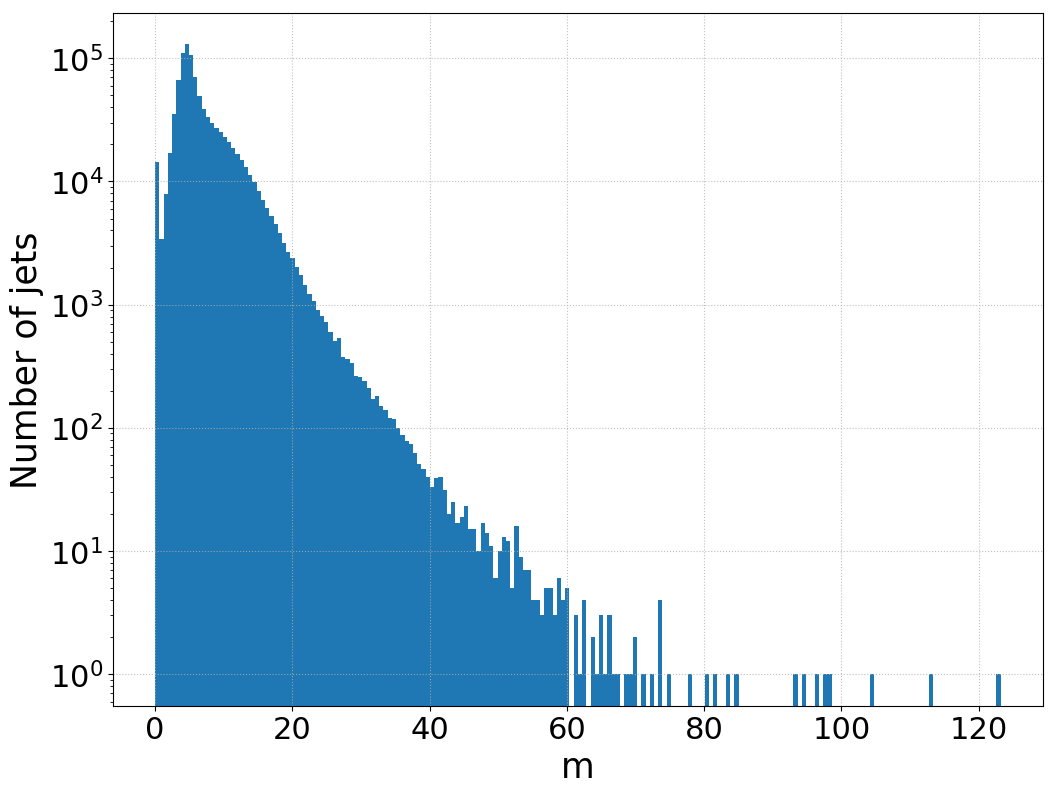

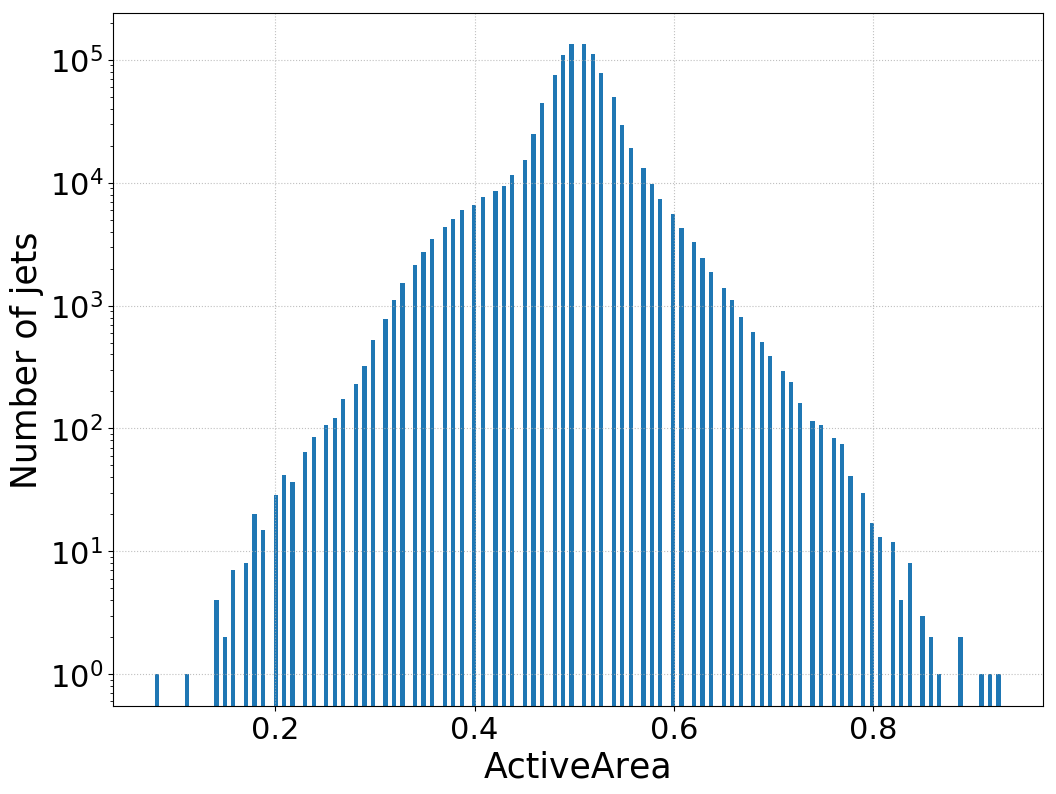

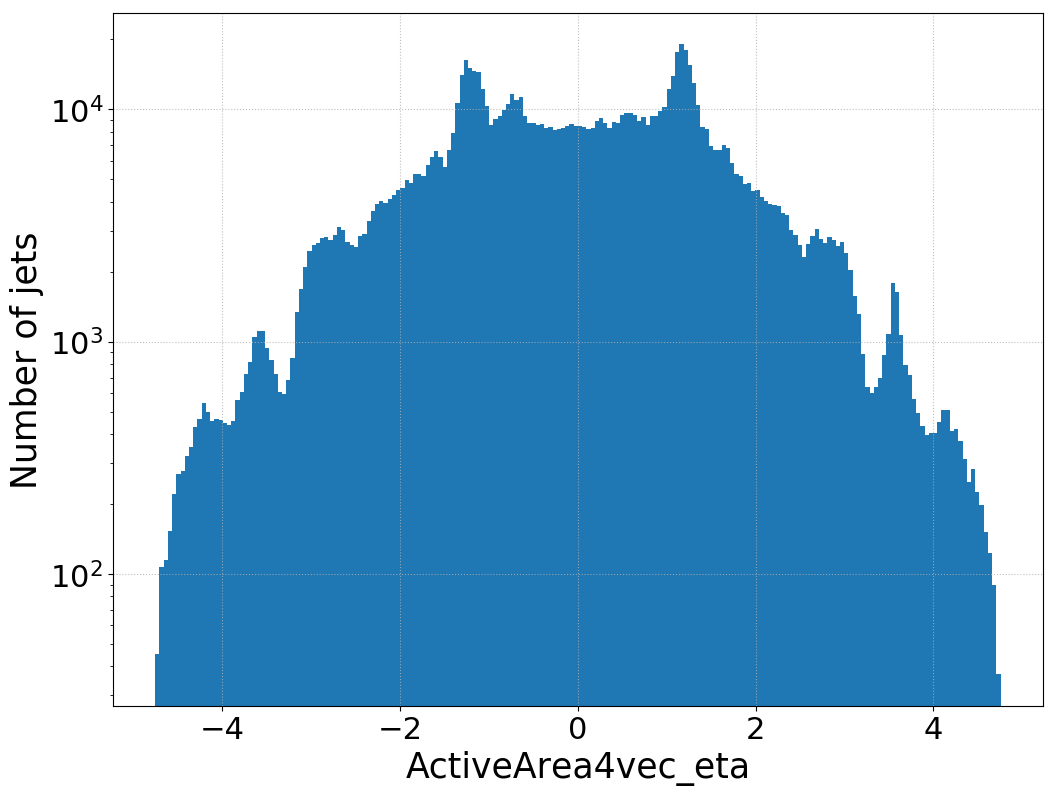

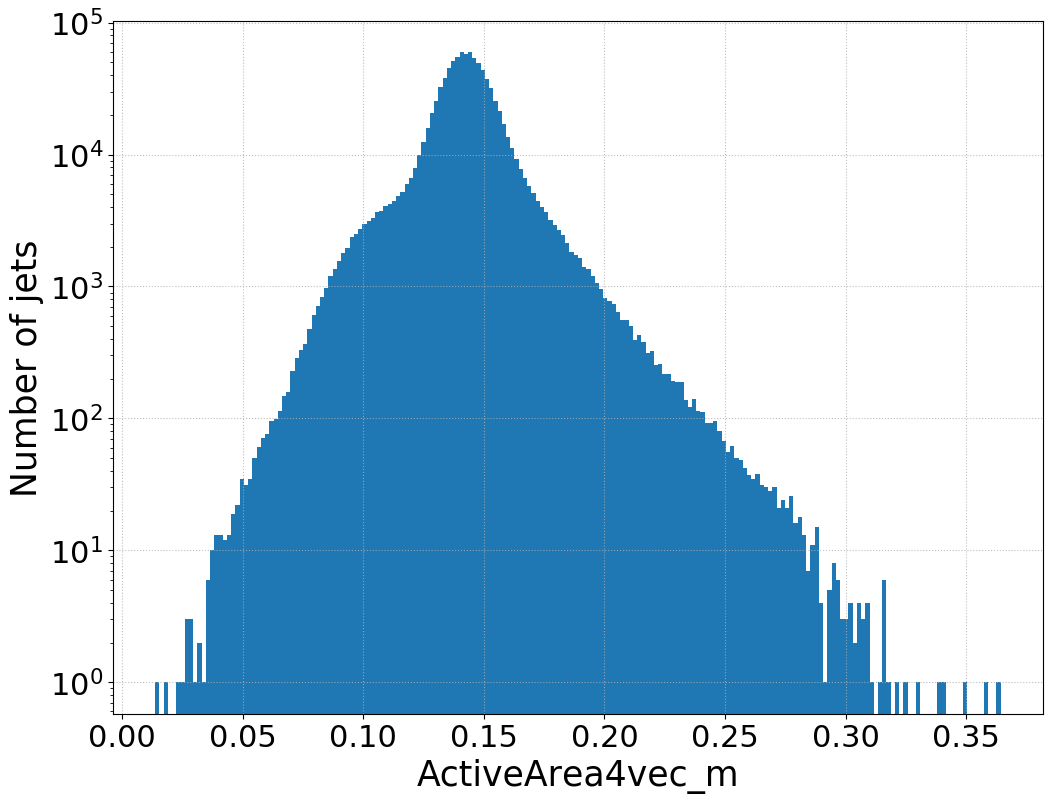

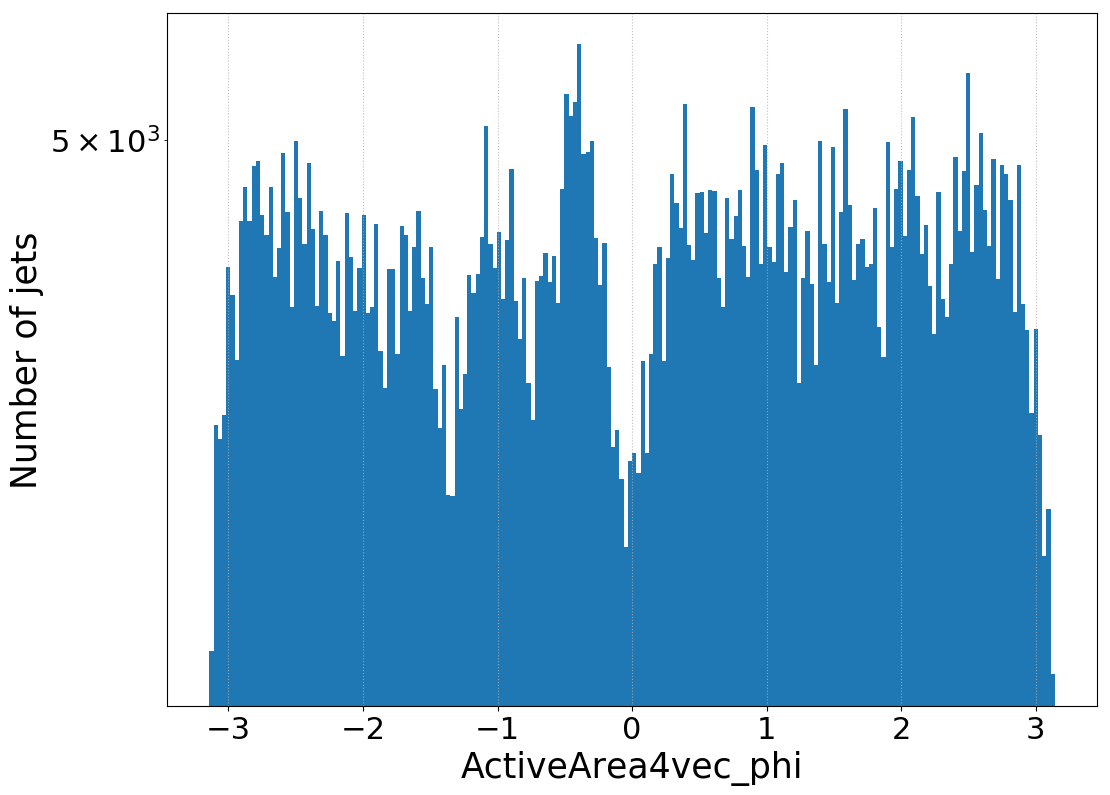

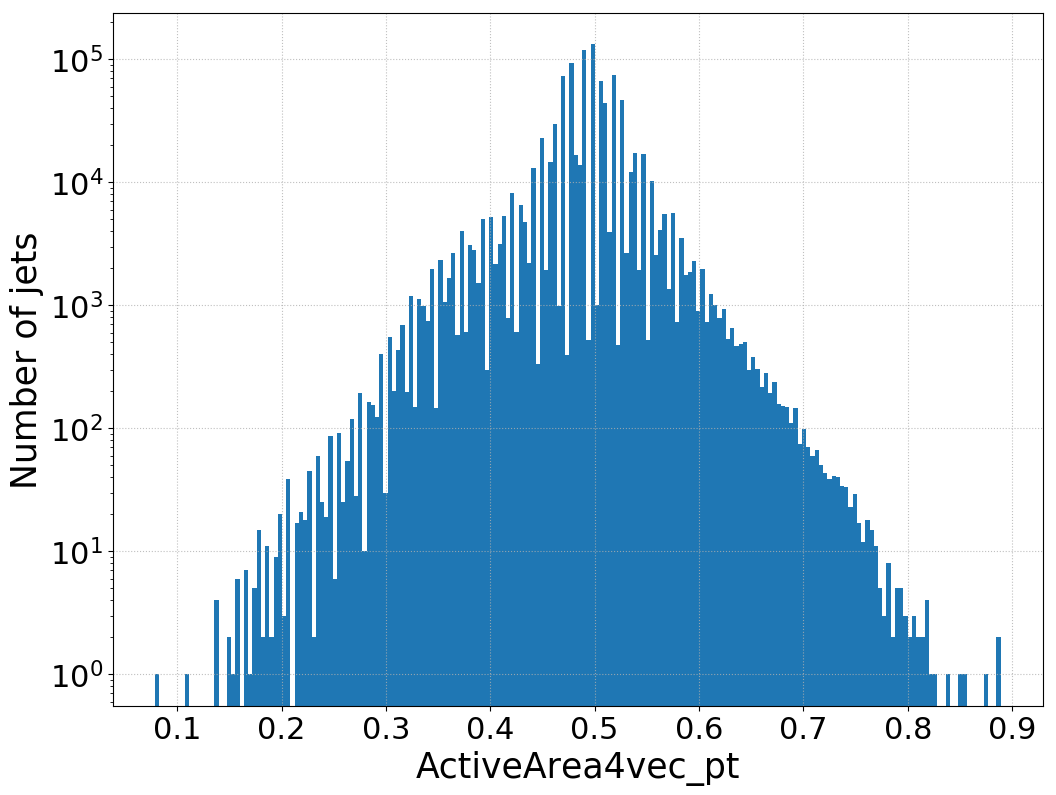

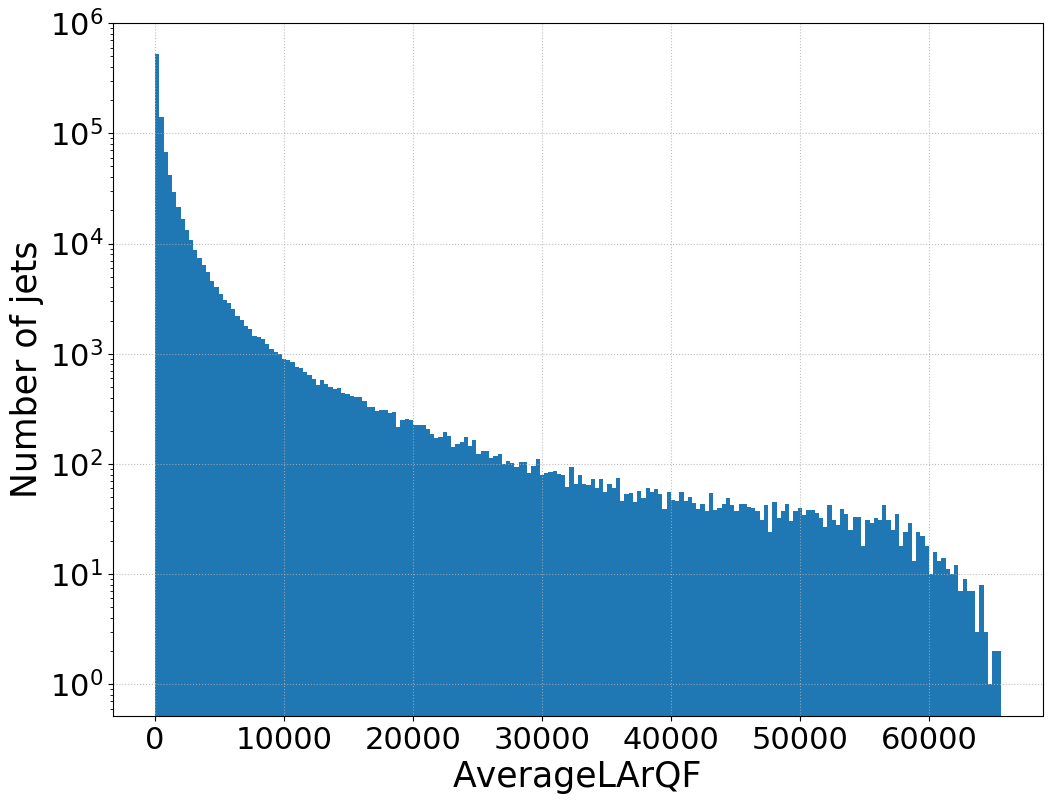

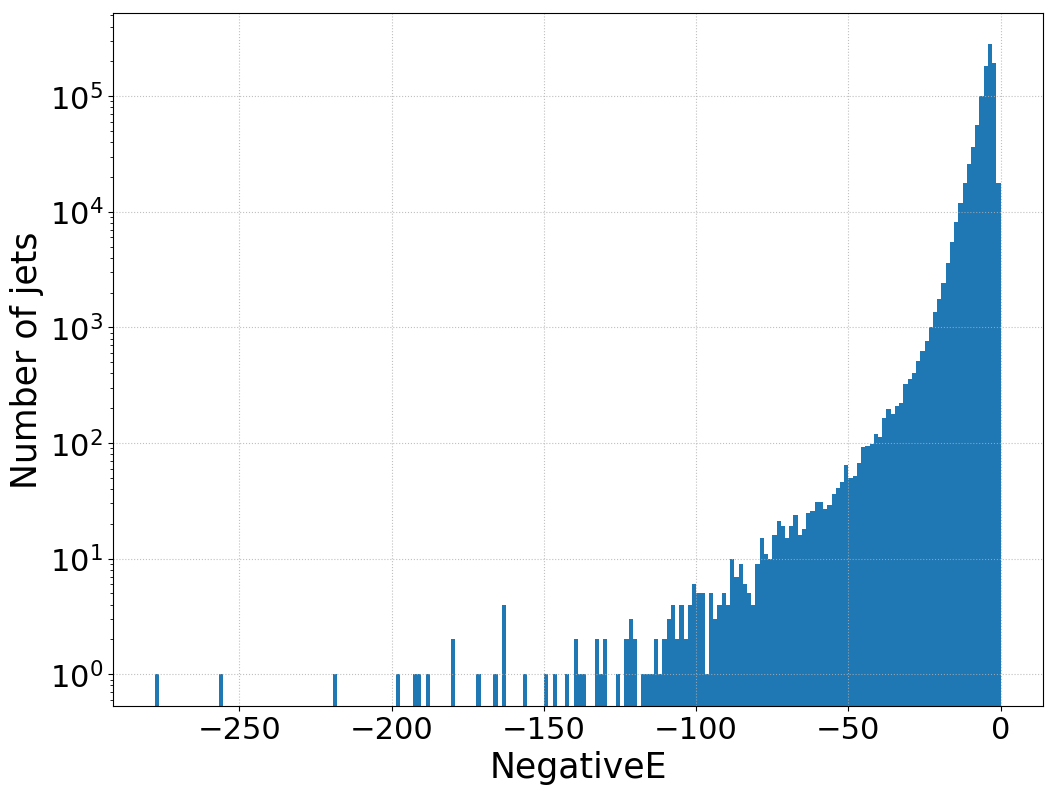

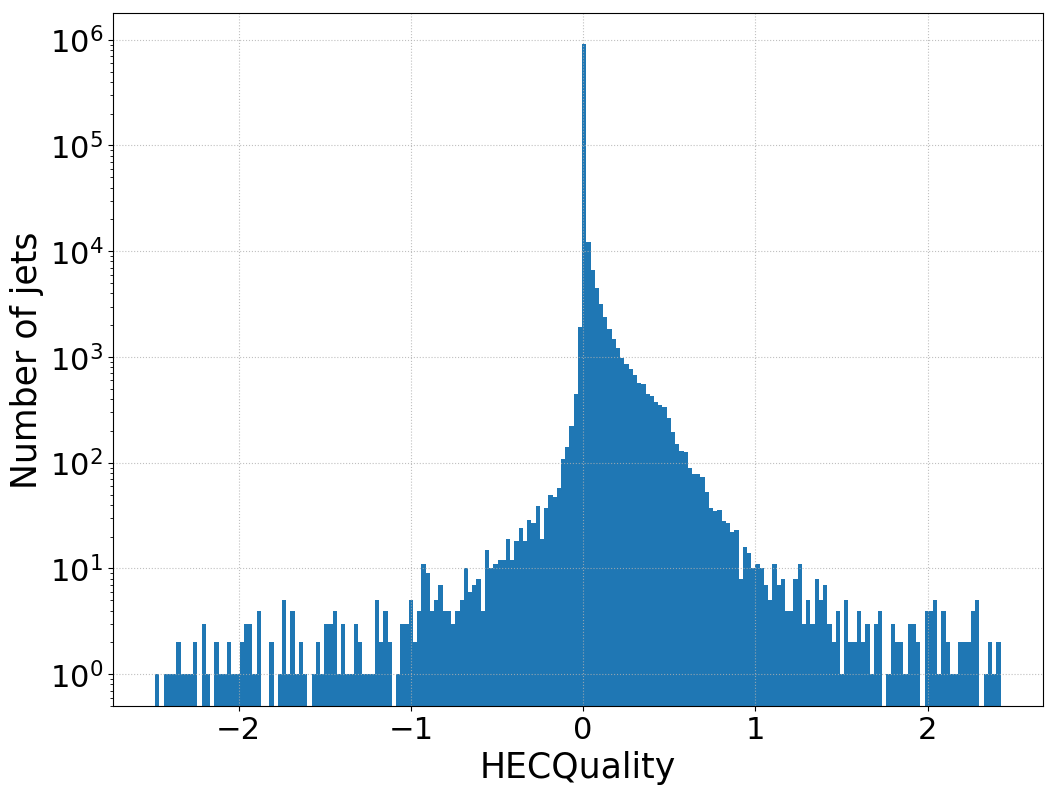

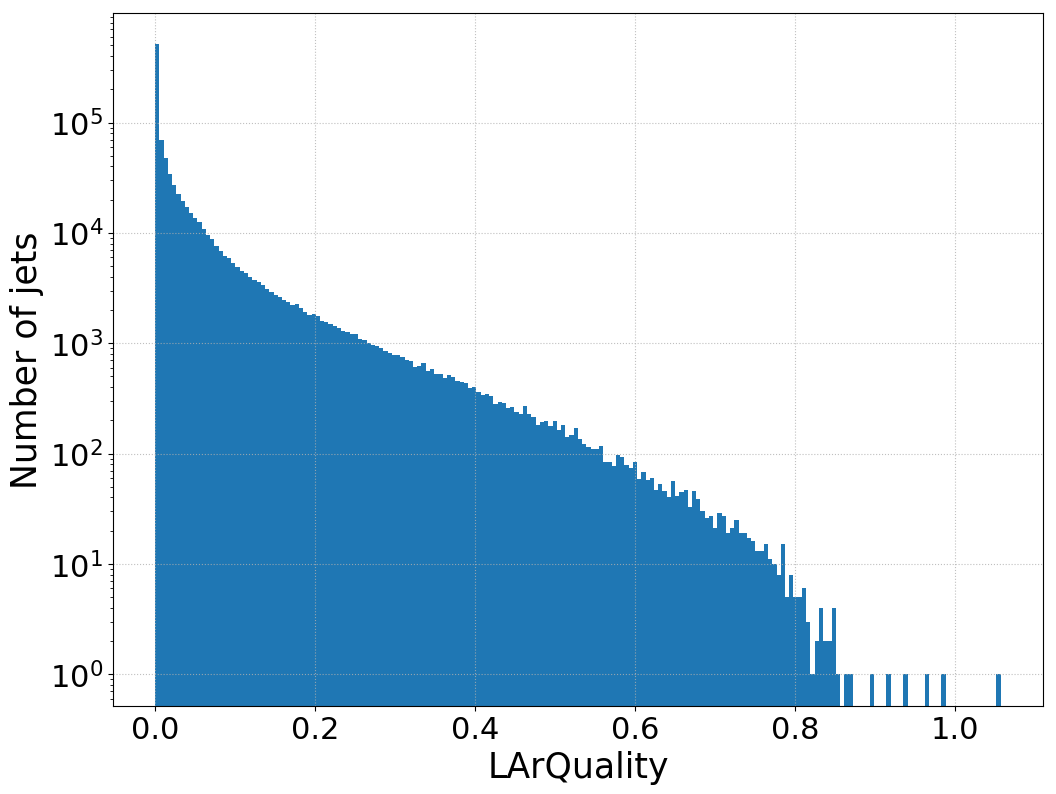

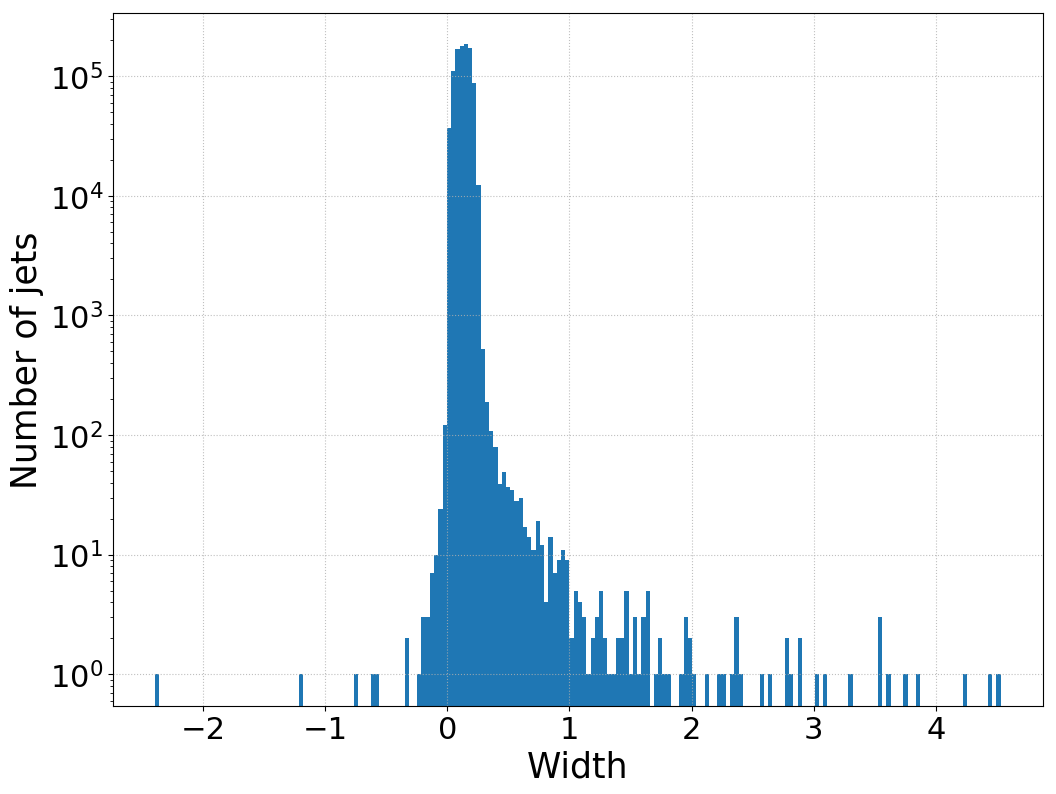

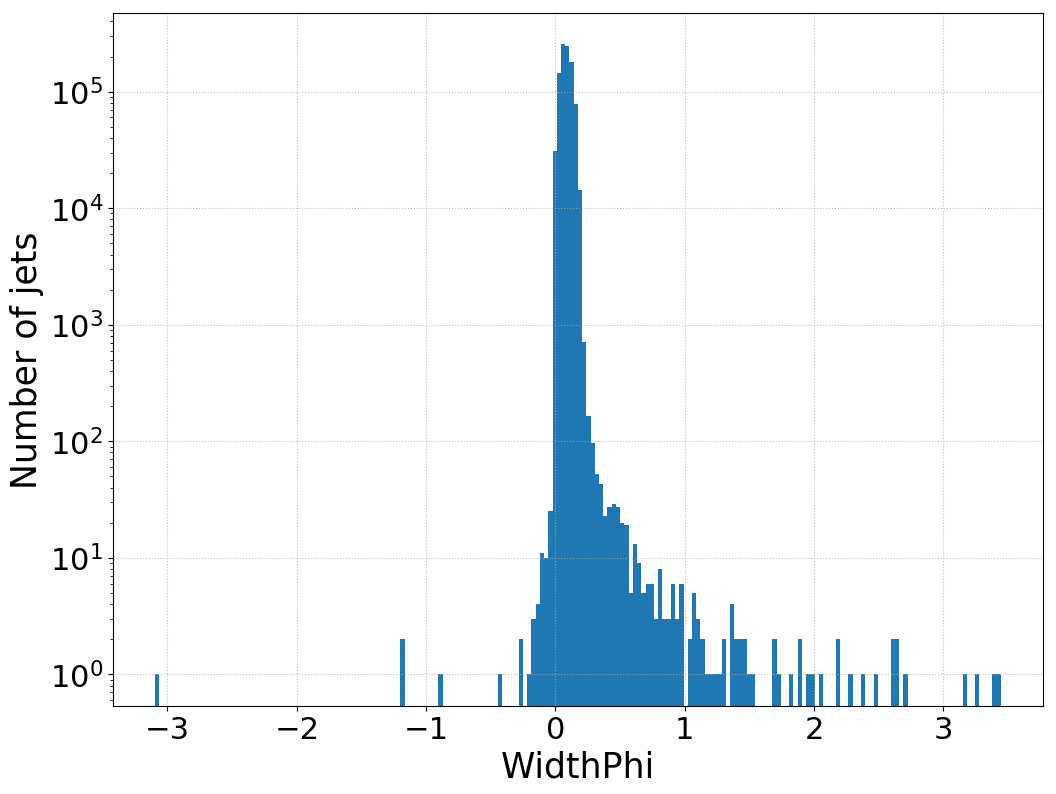

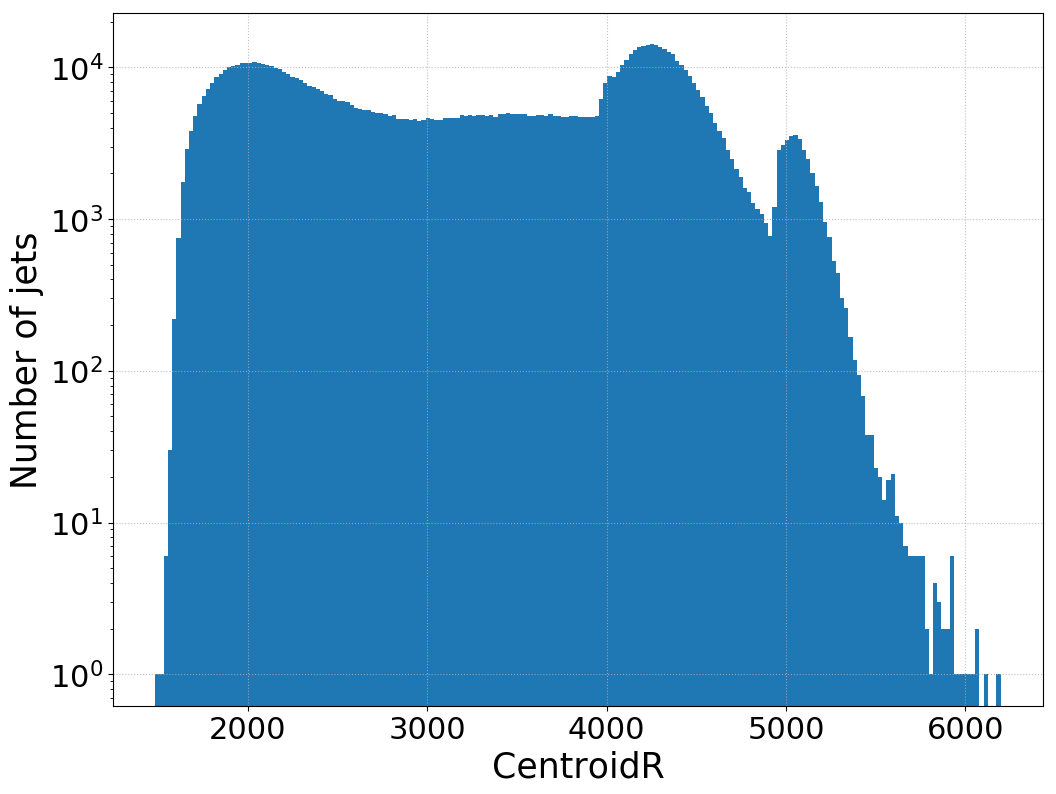

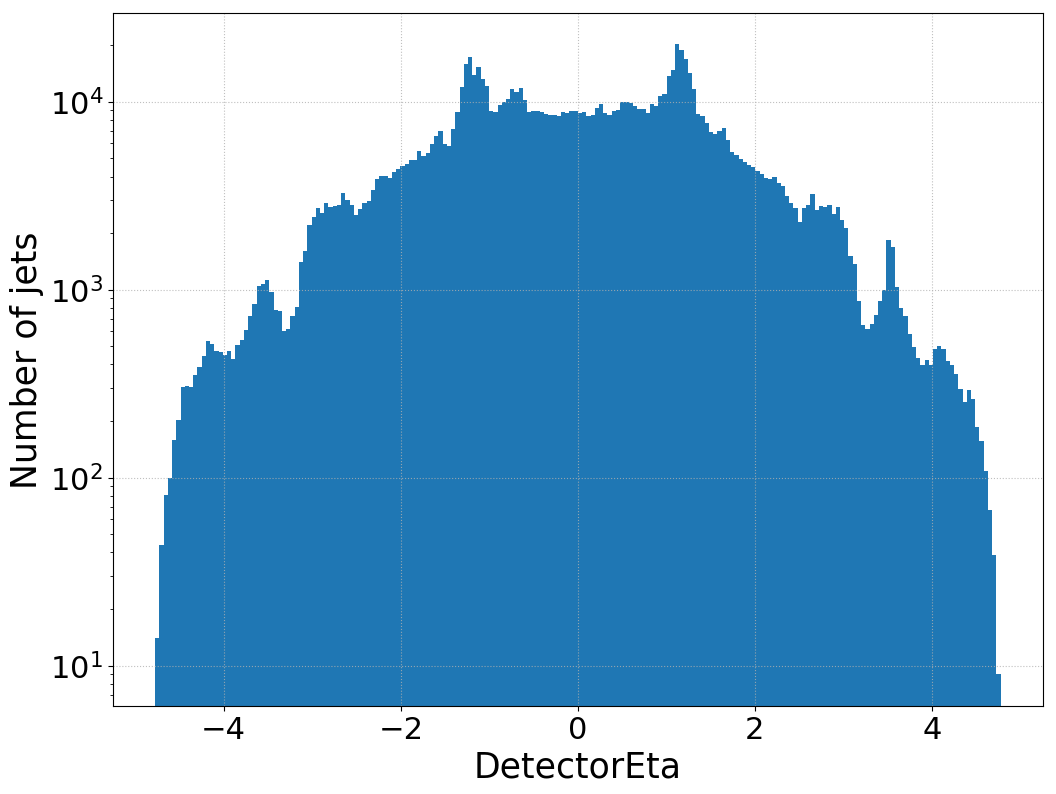

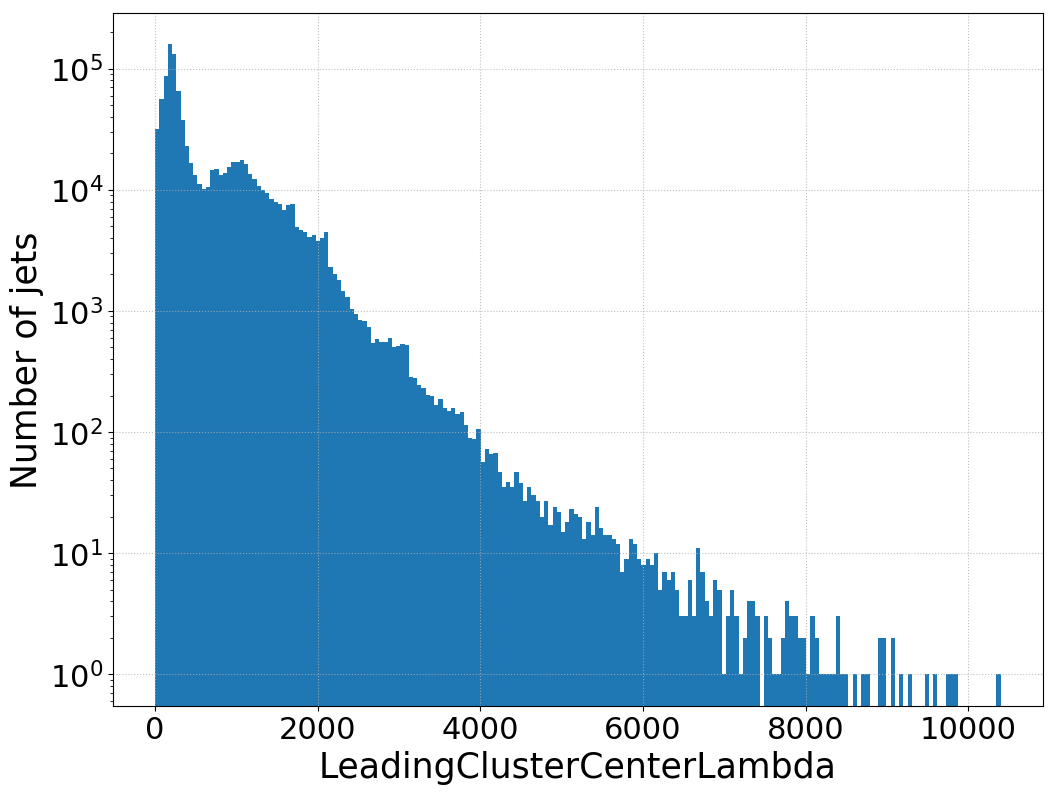

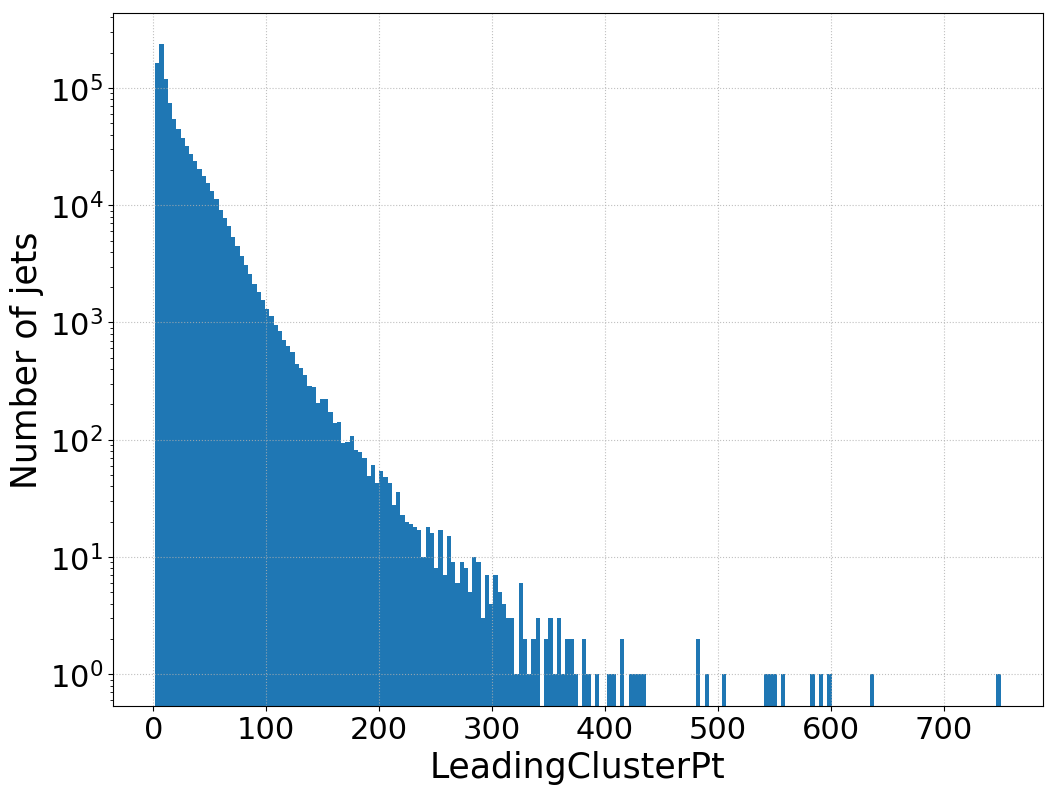

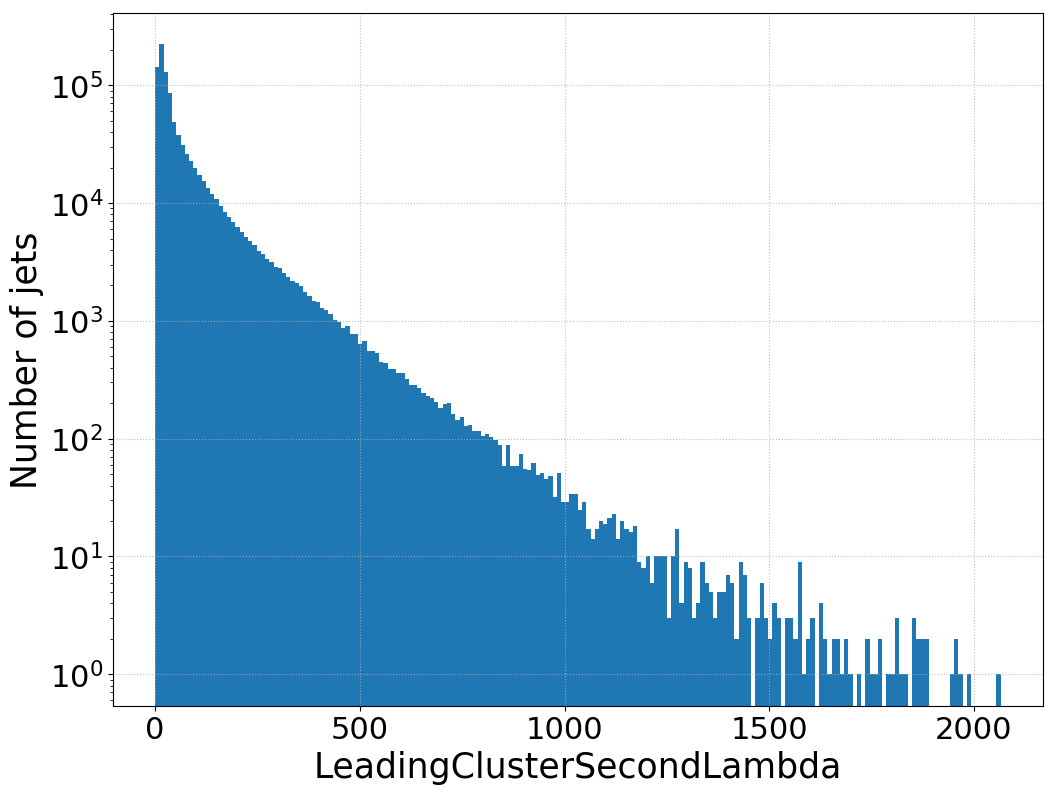

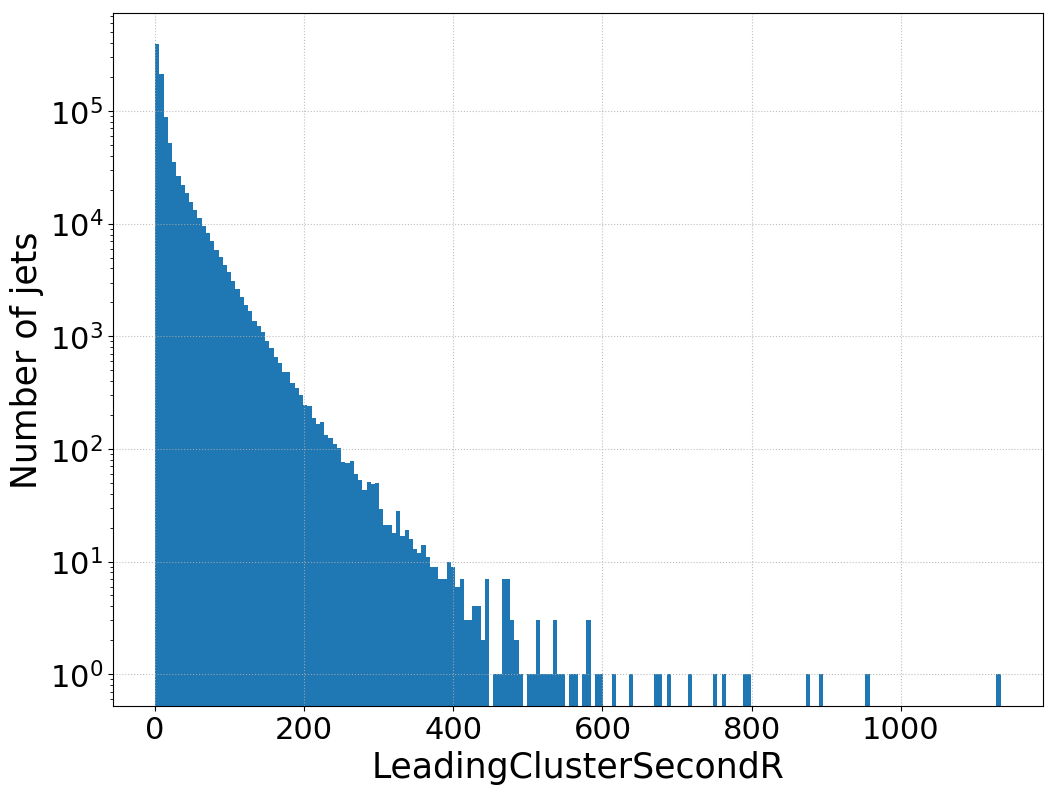

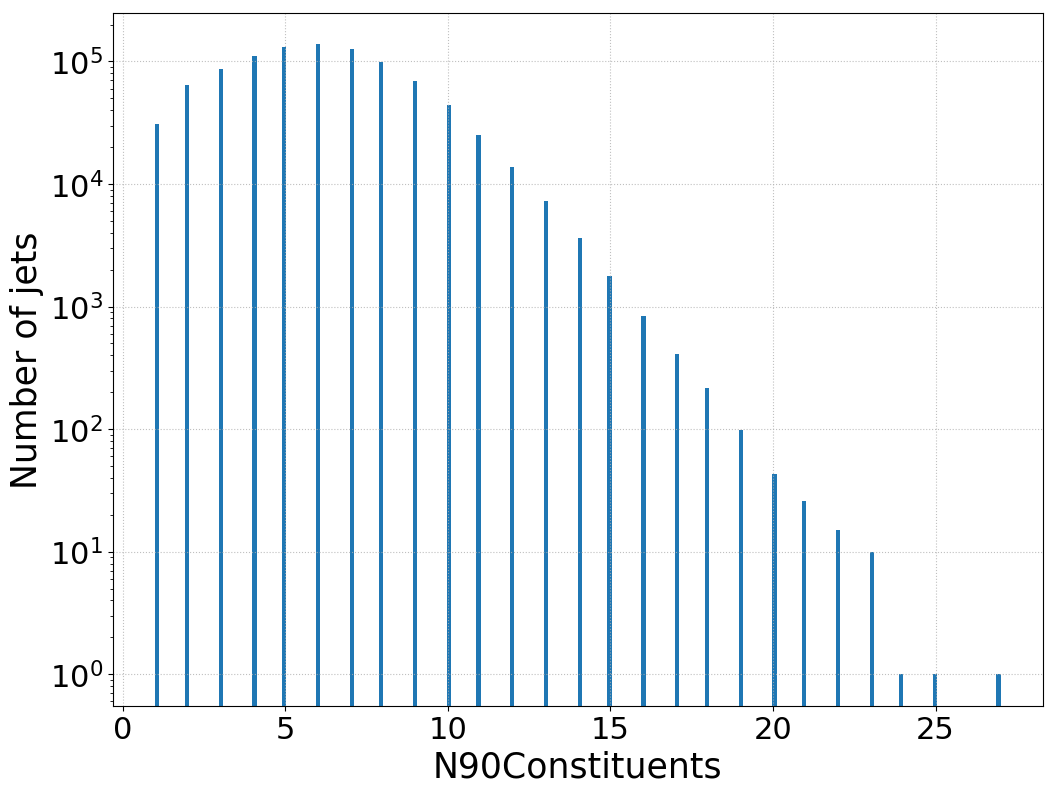

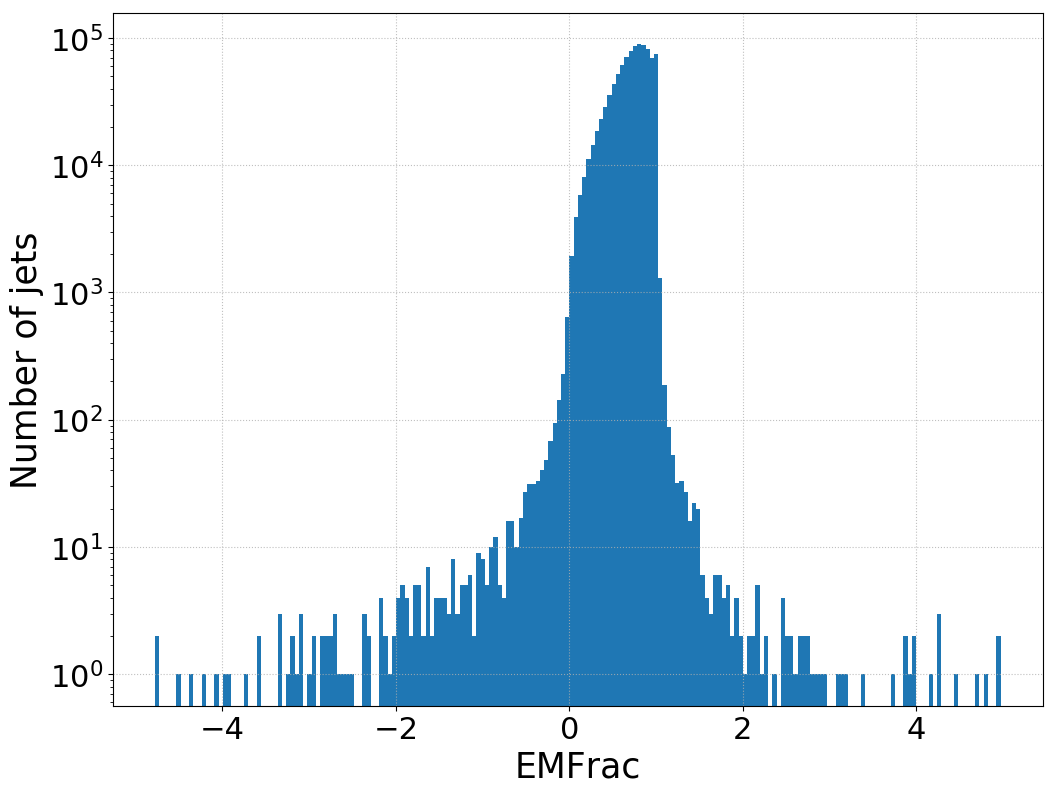

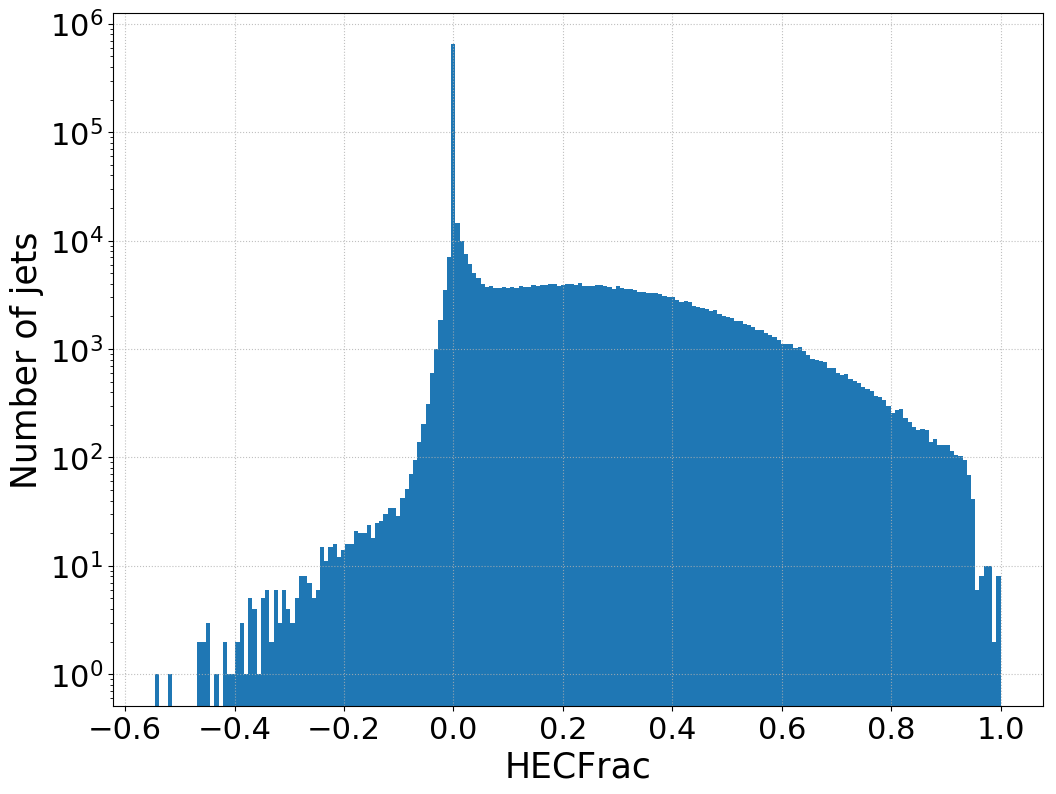

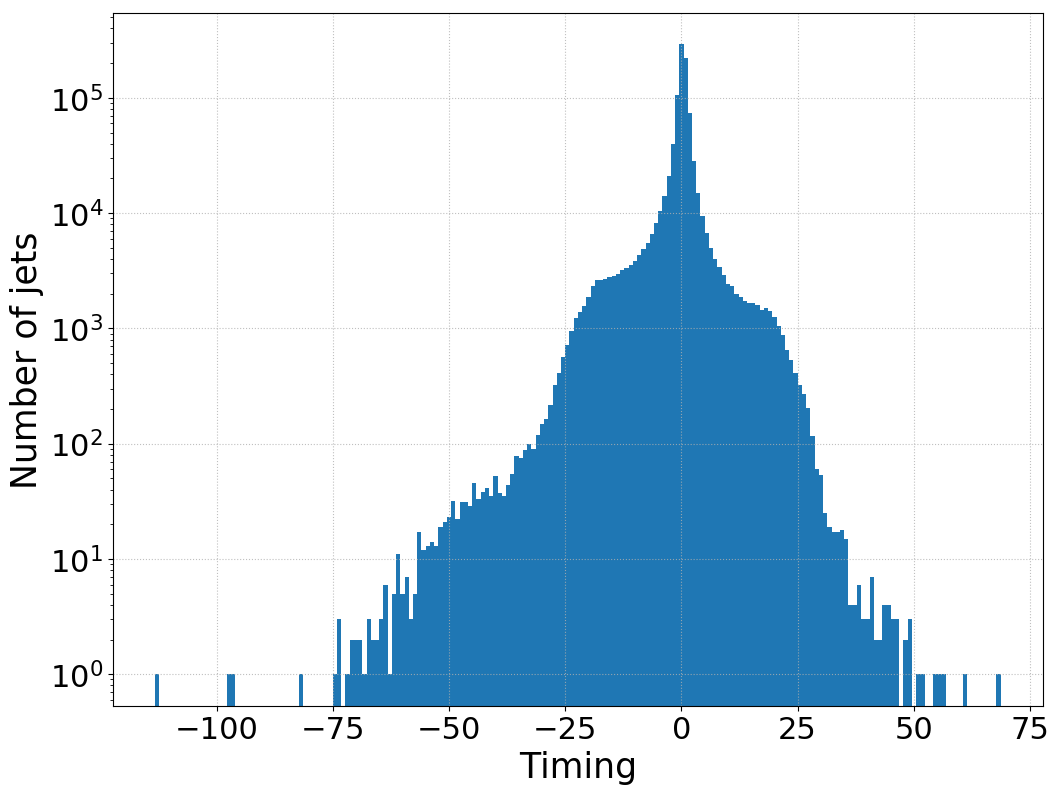

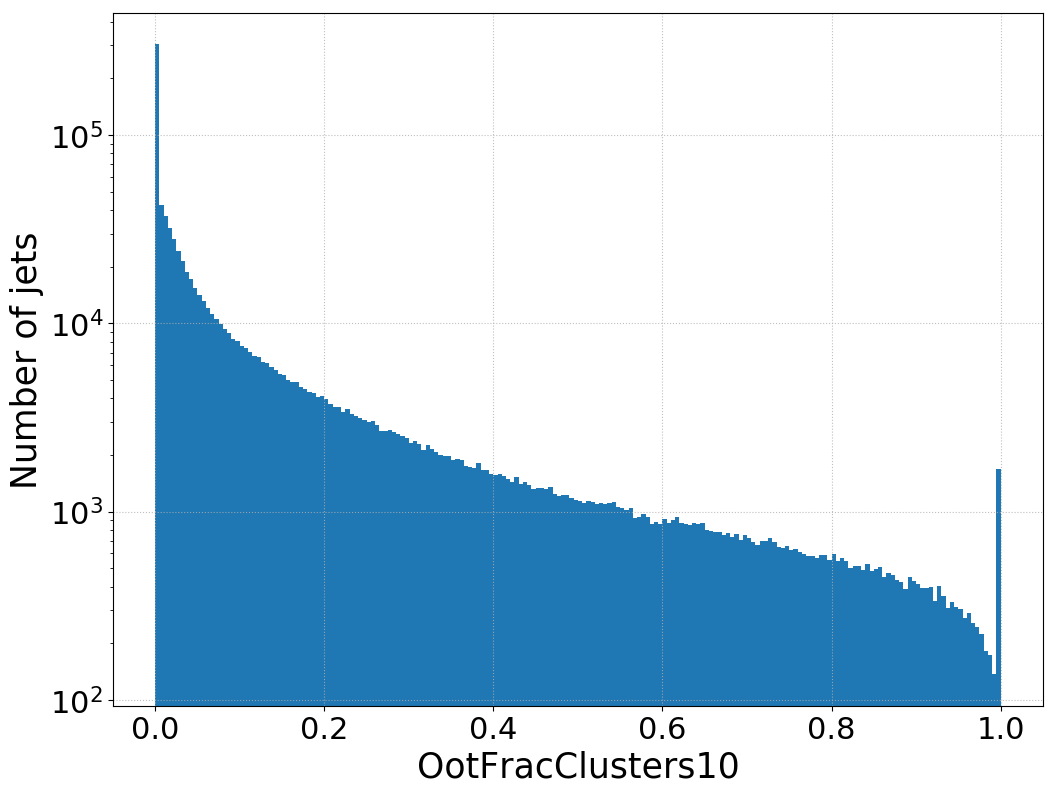

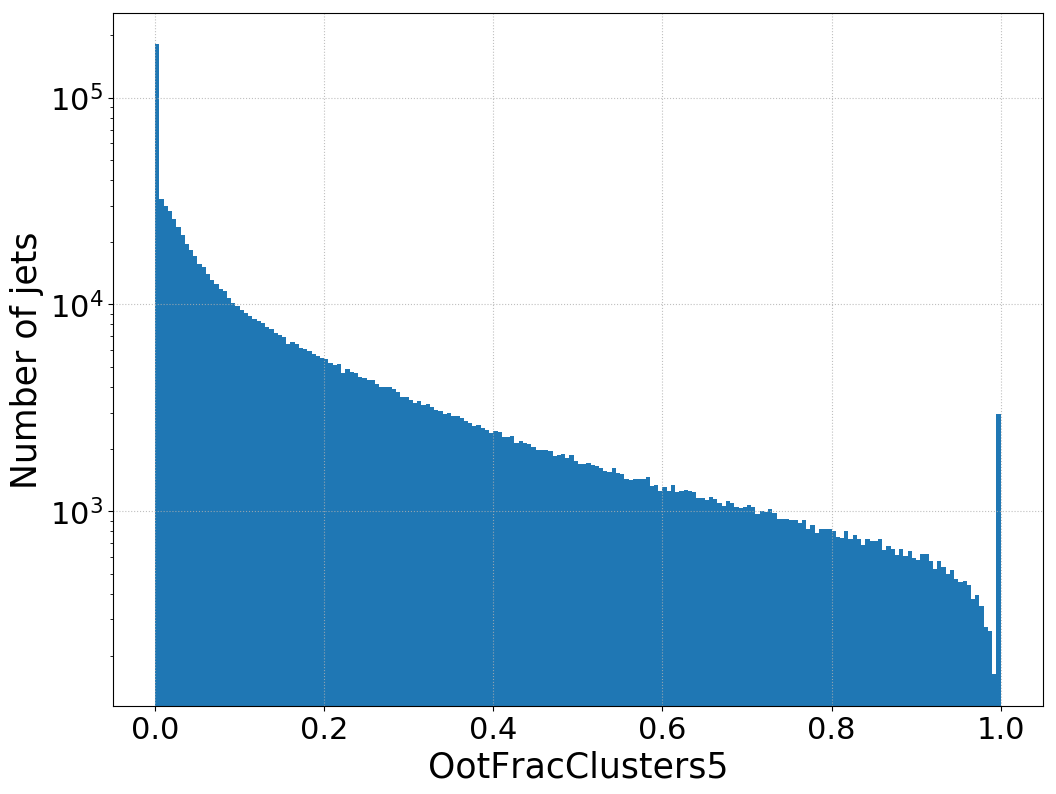

In [14]:
logy = True
plot_all(train, logy)

In [15]:
custom_normalized_train, custom_normalized_test = utils.custom_normalization(train, test)
unnormalized_test = utils.custom_unnormalize(custom_normalized_test)

In [16]:
# Checking if normalizing and unnormalizing works
(np.abs(test - unnormalized_test) < 1e-10).all()

pt                            True
eta                           True
phi                           True
m                             True
ActiveArea                    True
ActiveArea4vec_eta            True
ActiveArea4vec_m              True
ActiveArea4vec_phi            True
ActiveArea4vec_pt             True
AverageLArQF                  True
NegativeE                     True
HECQuality                    True
LArQuality                    True
Width                         True
WidthPhi                      True
CentroidR                     True
DetectorEta                   True
LeadingClusterCenterLambda    True
LeadingClusterPt              True
LeadingClusterSecondLambda    True
LeadingClusterSecondR         True
N90Constituents               True
EMFrac                        True
HECFrac                       True
Timing                        True
OotFracClusters10             True
OotFracClusters5              True
dtype: bool

In [15]:
#custom_normalized_train.to_pickle('../../processed_data/custom_normalized_train_10percent')
#custom_normalized_test.to_pickle('../../processed_data/custom_normalized_test_10percent')

In [16]:
#custom_normalized_train = pd.read_pickle('../../processed_data/aod/custom_normalized_train_10percent')
#ustom_normalized_test = pd.read_pickle('../../processed_data/aod/custom_normalized_test_10percent')